In [50]:
'''
Author       : Hanqing Qi
Date         : 2023-06-20 15:12:08
LastEditors  : Hanqing Qi
LastEditTime : 2023-06-20 15:12:21
FilePath     : /Blimps_Team/iPy_notebooks/Relative_Position_Test/Relative_Position_Test.ipynb
Description  : This is the simulation to test if the robot can get an estimate of its relative position with the information of the sender.
'''
# Import Packages
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import numpy as np

In [51]:
# Class to represent a cone
class Cone:
    def __init__(self, center, radius, starting_angle, end_angle):
        self.center = center  # center is a tuple (x, y)
        self.radius = radius  # radius is a float
        self.starting_angle = starting_angle  # starting angle is a float in degrees
        self.end_angle = end_angle  # end angle is a float in degrees

    def getCenter(self):
        return self.center

    def getRadius(self):
        return self.radius

    def getStartingAngle(self):
        return self.starting_angle

    def getEndAngle(self):
        return self.end_angle

    def rotate(self, angle):
        self.starting_angle += angle
        self.end_angle += angle
        self.starting_angle = self.starting_angle % 360
        self.end_angle = self.end_angle % 360

    def setCenter(self, center):
        self.center = center

    def drawCone(self, ax, my_color, start_angle, end_angle):
        wedge = patches.Wedge(
            self.center, self.radius, start_angle, end_angle, color=my_color, alpha=0.5
        )
        ax.add_patch(wedge)  # add the wedge to the plot

In [52]:
# Set up
Receiver_Pos = (-2, 3)
Sender_Speed = 20
Receiver_Speed = 13
Sender_1 = Cone((-2, 0), 5, 0, 359.9)
Sender_2 = Cone((2, 0), 5, 0, 359.9)
Receiver = Cone(Receiver_Pos, 5, 0, 60)

# Animation
Frame_Number = 400
Frame_Rate = 60

# Data
View_1 = []
View_2 = []
Log = [[], [], []]

In [53]:
# Functions
def In_Cone(cone_1, cone_2):
    '''
    description : Check if cone_1 is in cone_2
    return       [*] True if cone_1 is in cone_2 and false otherwise
    '''    
    # Convert the center of cone_1 to polar coordinates with cone_2 as the origin
    x = cone_1.getCenter()[0] - cone_2.getCenter()[0]
    y = cone_1.getCenter()[1] - cone_2.getCenter()[1]
    r = math.sqrt(x**2 + y**2)
    theta = math.degrees(math.atan2(y, x))
    if theta < 0:
        theta += 360

    # Check if the center of cone_1 is in cone_2
    if (r <= cone_2.getRadius()):
        if (cone_2.getStartingAngle() <= theta <= cone_2.getEndAngle()):
            return True
        elif (cone_2.getStartingAngle() >= cone_2.getEndAngle() and (cone_2.getStartingAngle() <= theta or theta <= cone_2.getEndAngle())):
            return True
    return False
    
def Save(View_1, View_2, Log):
    '''
    description : Save the data
    return       [*] None
    '''    
    np.save('View_1.npy', View_1)
    np.save('View_2.npy', View_2)
    np.save('Log.npy', Log)

In [54]:
# Simulation
for i in range(Frame_Number):
    # Save the sender and receiver data to log
    Log[0].append((Sender_1.getStartingAngle(), Sender_1.getEndAngle()))
    Log[1].append((Sender_2.getStartingAngle(), Sender_2.getEndAngle()))
    Log[2].append((Receiver.getStartingAngle(), Receiver.getEndAngle()))

    # Record the data received by the receiver
    if In_Cone(Sender_1, Receiver) and In_Cone(Receiver, Sender_1):
        
        View_1.append(1)
    else:
        View_1.append(0)
    if In_Cone(Sender_2, Receiver) and In_Cone(Receiver, Sender_2):
        View_2.append(1)
    else:
        View_2.append(0)

    Sender_1.rotate(Sender_Speed)
    Sender_2.rotate(Sender_Speed)
    Receiver.rotate(Receiver_Speed)

Save(View_1, View_2, Log)

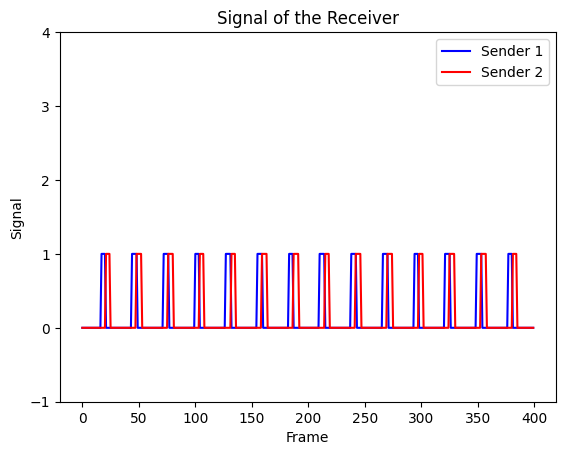

In [55]:
# Plot the signal of the sensors
fig, ax = plt.subplots()
ax.plot(View_1, 'b', label='Sender 1')
ax.plot(View_2, 'r', label='Sender 2')
ax.set_ylim([-1, 4])
ax.set_xlabel('Frame')
ax.set_ylabel('Signal')
ax.set_title('Signal of the Receiver')
ax.legend()
plt.savefig('Data-' + str(Receiver_Pos) + str(360) + '.png')
plt.show()

Rendering frames: 401it [00:15, 25.60it/s]                                      


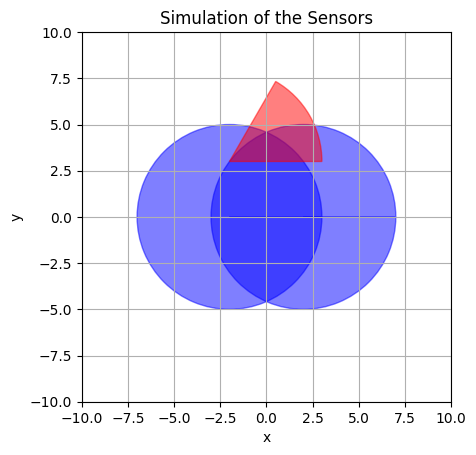

In [56]:
from tqdm import tqdm

# Create the animation
fig, ax = plt.subplots()


def animate(t):
    pbar.update()
    ax.clear()
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.title('Simulation of the Sensors')
    plt.xlabel('x')
    plt.ylabel('y')
    if View_1[t] == 1:
        Sender_1.drawCone(ax, 'g', Log[0][t][0], Log[0][t][1])
    else:
        Sender_1.drawCone(ax, 'blue', Log[0][t][0], Log[0][t][1])
    if View_2[t] == 1:
        Sender_2.drawCone(ax, 'g', Log[1][t][0], Log[1][t][1])
    else:
        Sender_2.drawCone(ax, 'blue', Log[1][t][0], Log[1][t][1])
    if View_1[t] == 1 or View_2[t] == 1:
        Receiver.drawCone(ax, 'g', Log[2][t][0], Log[2][t][1])
    else:
        Receiver.drawCone(ax, 'red', Log[2][t][0], Log[2][t][1])

    # Set the scale of the axis
    ax.set_aspect('equal', adjustable='box')
    ax.grid()


frame = np.arange(0, Frame_Number, 1)
pbar = tqdm(total=len(frame), desc="Rendering frames", ncols=80)
anim = FuncAnimation(
    fig, animate, frames=frame, interval=Frame_Rate
)  # interval increased for slower animation

# Save the animation as a mp4 file
anim.save('animation-' + str(Receiver_Pos) + str(360) + '.mp4', writer='ffmpeg')
pbar.close()